In [10]:
import os
import sys
import time
import calendar
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def read_prices(directory, start_year, end_year):
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    filenames = []
    for year in range(start_year, end_year + 1):
        for month in month_order:
            filename = f"ERCOT_{month}_{year}.csv"
            filepath = os.path.join(directory, filename)
            if os.path.exists(filepath):
                filenames.append(filepath)
    p_list = []
    times_list = []
    for file in filenames:
        df = pd.read_csv(file, usecols=['lmp_dam', 'interval_start_utc'], dtype={'lmp_dam': 'float64'})
        p_list.append(df['lmp_dam'].values)
        times_list.append(pd.to_datetime(df['interval_start_utc']))
    p = np.concatenate(p_list)
    return p

def repeat_single_year_data_with_leap_years(p, start_year=2000, end_year=2029):
    new_p_list = []
    for year in range(start_year, end_year + 1):
        if calendar.isleap(year):
            new_p_list.append(p)
        else:
            # Remove entries corresponding to February 29th
            p_non_leap = np.concatenate((p[:1416], p[1440:]))
            new_p_list.append(p_non_leap)
    new_p = np.concatenate(new_p_list)
    return new_p

def horizon(x, H):
    number_of_samples = len(x) - H
    future = np.zeros((number_of_samples,H))
    c = 0
    for i in range(len(x) - H):
        future_slice = x[i:i+H]
        future[c] = future_slice
        c += 1
    return future

def generate_intervals_2_weeks(year):
    intervals = []
    for month in [1,6]:
        start_time = f"{year}-{month:02d}-01 00:00"
        end_time = f"{year}-{month:02d}-07 23:00"
        intervals.append((start_time, end_time))
    return intervals

directory = '../ercot/prices'
single_year_prices = read_prices(directory, 2012, 2012)
single_year_times = pd.date_range(start='2012-01-01 00:00', end='2012-12-31 23:00', freq='h')
start_year = 2012
end_year = 2036
prices = repeat_single_year_data_with_leap_years(single_year_prices, start_year, end_year)
times = pd.date_range(start=f'{start_year}-01-01 00:00', end=f'{end_year}-12-31 23:00', freq='h')
assert len(prices) == len(times)
H = 24
f_test = horizon(prices, H)

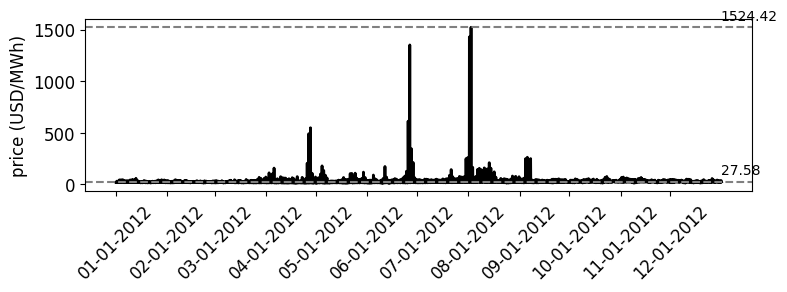

In [11]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012.pdf'
file_path = os.path.join(output_dir, file_name)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(single_year_times, single_year_prices, label='price', color='black', linewidth=2)
ax.set_ylabel(f'price (USD/MWh)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
ax.axhline(y=np.mean(single_year_prices), color='gray', linestyle='--', label='mean')
ax.axhline(y=np.max(single_year_prices), color='gray', linestyle='--', label='max')
ax.annotate(f'{np.mean(single_year_prices):.2f}', xy=(single_year_times[-10], np.mean(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.annotate(f'{np.max(single_year_prices):.2f}', xy=(single_year_times[-10], np.max(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.set_xticks(pd.date_range(start=single_year_times.min(), end=single_year_times.max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

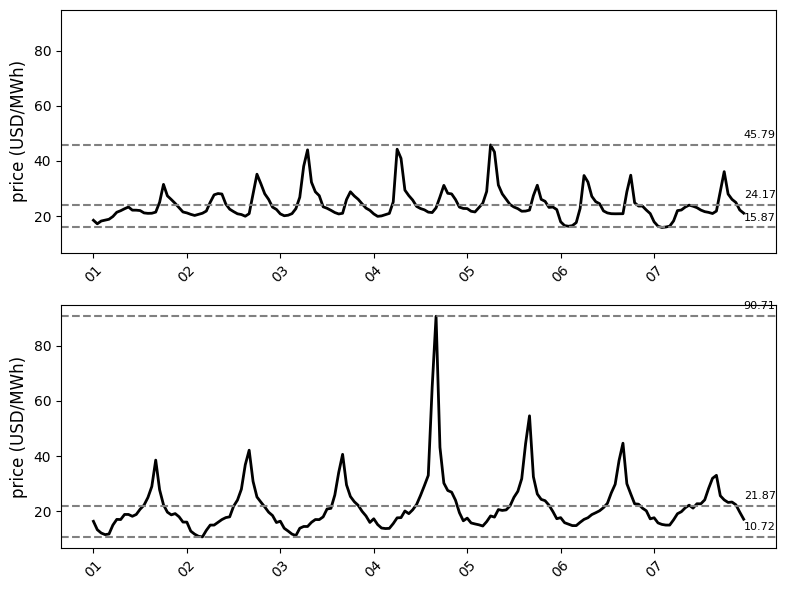

In [12]:
intervals = generate_intervals_2_weeks(2012)
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012_weekly.pdf'
file_path = os.path.join(output_dir, file_name)
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
axes = axes.flatten()
for idx, (start_time, end_time) in enumerate(intervals):
    mask = (times >= start_time) & (times <= end_time)
    p_subset = prices[mask]
    times_subset = times[mask]
    ax = axes[idx]
    if len(p_subset) > 0:
        ax.plot(times_subset, p_subset, label='Price', color='black', linewidth=2)
        ax.set_ylabel('price (USD/MWh)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(False)
        ax.axhline(y=np.mean(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.max(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.min(p_subset), color='gray', linestyle='--')
        if len(times_subset) >= 10:
            ax.annotate(f'{np.mean(p_subset):.2f}', xy=(times_subset[-1], np.mean(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.max(p_subset):.2f}', xy=(times_subset[-1], np.max(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.min(p_subset):.2f}', xy=(times_subset[-1], np.min(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
    ax.set_xticks(pd.date_range(start=start_time, end=end_time, freq='d'))
    ax.xaxis.set_major_formatter(DateFormatter('%d'))
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [13]:
cell_constants = {
    'H' : H,
    'C_max' : 0.33, # 1/h
    'tilde_Q_1' : 2.5, # Ah
    'tilde_V' : 3.3, # V
    'N' : 0.5, # divided by 1e6
    'cons_z': 0.60,
    'cons_alpha': 28.966,
    'cons_beta': 74.112,
    'cons_delta': 1,
    'cons_eta': 152.5,
    'cons_E_a': 31500,
    'cons_R_g': 8.314,
    'cons_T': 273.15 + 25, # K
    'cons_omega': np.exp(-31500 / (8.314 * (273.15 + 25))),
        # --- NEW ---
    'SoH_target': 0.80          # required remaining capacity at end of each horizon
    }

def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

def arbitrage_problem(cell_constants):
    H = cell_constants['H']

    # ------------- PARAMETERS -------------
    p_H               = cp.Parameter((H,), nonneg=True, name='p_H')
    tilde_Q_t         = cp.Parameter(nonneg=True, name='tilde_Q_t')
    tilde_Q_target    = cp.Parameter(nonneg=True, name='tilde_Q_target')
    tilde_B_t         = cp.Parameter(nonneg=True, name='tilde_B_t')
    tilde_q_t_1       = cp.Parameter(nonneg=True, name='tilde_q_t_1')
    aging_coeff_t     = cp.Parameter(nonneg=True, name='aging_coeff_t')
    mu                = cp.Parameter(nonneg=True, name='mu')
    SoH_target        = cp.Parameter(nonneg=True, name='SoH_target')   # ★ NEW ★

    # ------------- VARIABLES --------------
    tilde_q           = cp.Variable(H+1, nonneg=True, name='tilde_q')
    tilde_b           = cp.Variable(H,     name='tilde_b')
    tilde_delta_q_t   = cp.Variable(name='tilde_delta_q_t')

    # ------------- OBJECTIVE --------------
    objective = (1/H) * (
        -cp.sum(cp.multiply(p_H,
                            tilde_b*cell_constants['cons_delta']
                                   *cell_constants['tilde_V']
                                   *cell_constants['N']))
        + aging_coeff_t*1e5*cp.sum(cp.abs(tilde_b))
    ) + mu * cp.sum_squares(tilde_delta_q_t)

    # ------------- CONSTRAINTS -------------
    constraints = [
        cp.diff(tilde_q) == -tilde_b*cell_constants['cons_delta'],
        cp.abs(tilde_b)  <=  tilde_B_t,
        tilde_q[1:]      <=  tilde_Q_t,
        tilde_q[0]       ==  tilde_q_t_1,
        tilde_delta_q_t  ==  tilde_q[-1] - tilde_Q_target,
        # ★ Terminal-SoH constraint ★
        tilde_q[-1]      >=  SoH_target * cell_constants['tilde_Q_1']
    ]

    return cp.Problem(cp.Minimize(objective), constraints)


def arbitrage_set_parameter_values(prob, p_H, tilde_Q_t, tilde_q_t_1,
                                   tilde_Q_target, tilde_B_t,
                                   aging_coeff_t, mu, SoH_target):
    prob.param_dict['p_H'].value            = p_H
    prob.param_dict['tilde_Q_t'].value      = tilde_Q_t
    prob.param_dict['tilde_q_t_1'].value    = tilde_q_t_1
    prob.param_dict['tilde_Q_target'].value = tilde_Q_target
    prob.param_dict['tilde_B_t'].value      = tilde_B_t
    prob.param_dict['aging_coeff_t'].value  = aging_coeff_t
    prob.param_dict['mu'].value             = mu
    prob.param_dict['SoH_target'].value     = SoH_target      # ★ NEW ★
    return prob

def arbitrage_retrieve(problem):
    tilde_b = problem.var_dict['tilde_b'].value
    tilde_q = problem.var_dict['tilde_q'].value
    tilde_delta_q_t = problem.var_dict['tilde_delta_q_t'].value
    return tilde_b, tilde_q, tilde_delta_q_t

In [14]:
def arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma):
    # Shapes
    E = f_test.shape[0]
    H = f_test.shape[1]
    # Problem
    problem = arbitrage_problem(cell_constants)
    # Pre-allocate battery-level variables
    revenue = np.zeros((E,)) # USD
    p = np.zeros((E,)) # MW
    hat_p = np.zeros((E,H))
    # Pre-allocate cell-level variables
    tilde_b = np.zeros((E,)) # A
    tilde_q = np.zeros((E,)) # Ah
    tilde_delta_q = np.zeros((E,))
    tilde_hat_q = np.zeros((E,H))
    tilde_Q = np.ones((E,)) * cell_constants['tilde_Q_1'] # Ah
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))
    # Initialize cell-level variables
    tilde_Q_t = tilde_Q[0]
    tilde_Q_target = cons_frac*tilde_Q_t
    tilde_q_t = tilde_Q_t
    tilde_q_t_1 = tilde_Q_t
    tilde_B_t = cell_constants['C_max'] * tilde_Q_t
    tilde_b_t = 0
    # Initialize cell-level running variables
    ah_t = 2.5
    Sigma_rho_t = 0
    # Initialize aging
    l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
    mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
    aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
    # -----------------------------------LOOP-----------------------------------
    for e in range(E):    
        hat_p[e] = f_test[e]
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break


        SoH_target_val = 0.80                    # 80 % 
        problem =        arbitrage_set_parameter_values(
                   problem, f_test[e], tilde_Q_t, tilde_q_t_1,
                   tilde_Q_target, tilde_B_t, aging_coefficient_t,
                   cons_mu, cell_constants['SoH_target'])

        try:
            problem.solve(solver=cp.CLARABEL, verbose=False)
        except cp.error.SolverError:          # numerical failure, etc.
            print(f"Warning: cp.error.SolverError for {e}")
            return None                       # tell the caller to skip this γ

        if problem.status not in ["optimal", "optimal_inaccurate"]:
            # MPC became infeasible because of the terminal-SoH constraint
            print(f"Warning: infeasible terminal-SoH constraint for {e}")
            return None


        tilde_b_H, tilde_q_H, tilde_delta_q_t = arbitrage_retrieve(problem)
        # Update battery-level variables
        p_t = f_test[e][0]
        tilde_hat_q[e] = tilde_q_H[1:]
        tilde_b_t = tilde_b_H[0]
        revenue_t = p_t*tilde_b_t*cell_constants['cons_delta']*cell_constants['tilde_V']*cell_constants['N']
        # Update running variables
        ah_t = ah_t + (abs(tilde_b_t)*cell_constants['cons_delta'])
        #------------------------
        tilde_q_t = tilde_q_H[1]
        tilde_q_t_1 = tilde_q_H[1]
        # Update aging
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
        aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
        tilde_B_t = cell_constants['C_max']*tilde_Q_t
        tilde_Q_target = cons_frac*tilde_Q_t
        # Assign battery-level variables
        p[e] = p_t
        revenue[e] = revenue_t
        # Assign cell-level variables
        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        tilde_delta_q[e] = tilde_delta_q_t
        l[e] = l_t
        ah[e] = ah_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t
        Sigma_rho[e] = Sigma_rho_t
    
    # ----------------------------END LOOP----------------------------
    num_hours = e
    # Trim battery-level variables
    revenue = revenue[:num_hours]
    p = p[:num_hours]
    hat_p = hat_p[:num_hours]
    # Gross metrics
    battery_lifetime = num_hours/(365*24*(1/cell_constants['cons_delta']))
    ah_at_the_end = ah[num_hours-1]
    # Trim cell-level variables
    tilde_b = tilde_b[:num_hours]
    tilde_Q = tilde_Q[:num_hours]
    tilde_q = tilde_q[:num_hours]
    tilde_delta_q = tilde_delta_q[:num_hours]
    tilde_hat_q = tilde_hat_q[:num_hours]
    l = l[:num_hours]
    ah = ah[:num_hours]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:num_hours]
    Sigma_rho = Sigma_rho[:num_hours]
    # Battery-level variables
    battery_variables = {'revenue': revenue, 'p': p, 'hat_p': hat_p}
    # Cell-level variables
    cell_variables = {'tilde_b': tilde_b, 
                      'tilde_Q': tilde_Q, 
                      'tilde_q': tilde_q, 
                      'tilde_delta_q': tilde_delta_q, 
                      'tilde_hat_q': tilde_hat_q, 
                      'l': l, 
                      'ah': ah, 
                      'mu_one_plus_nu_q': mu_one_plus_nu_q,
                      'Sigma_rho': Sigma_rho}
    

    return battery_variables, cell_variables, battery_lifetime, ah_at_the_end

import time
import numpy as np

def experiment_loop(
    f_test,
    cell_constants,
    gammas=None,
    cons_frac=0.5,
    cons_mu=0.0,
    continue_on_fail=True,   # 失败是否继续
    fail_policy="nan"        # 失败占位策略: "nan" -> 用 np.nan/None 占位；"skip" -> 直接跳过不加入列表
):
    """
    运行一组 gamma 扫描实验，鲁棒处理 arbitrage_experiment 返回 None/异常的情况。
    返回: bvs, cvs, bls, ahs（长度与成功/占位一致；若 fail_policy='skip' 则为成功项长度）
    """
    if gammas is None:
        # gammas = np.logspace(0, 3.5, 10)
        gammas = np.linspace(0, 30, 9)

    num_experiments = len(gammas)
    bvs, cvs, bls, ahs = [], [], [], []
    failed = 0

    def _parse_result(ret):
        # None 直接判失败
        if ret is None:
            return None
        # 字典返回：取常用键名
        if isinstance(ret, dict):
            b = ret.get("battery_variables")
            c = ret.get("cell_variables")
            bl = ret.get("battery_lifetime")
            ah = ret.get("ah_at_the_end") or ret.get("ah_end") or ret.get("Ah_end")
            if (b is not None) and (c is not None) and (bl is not None) and (ah is not None):
                return b, c, bl, ah
            else:
                return None
        # 元组/列表返回：期望 4 元
        if isinstance(ret, (tuple, list)):
            if len(ret) == 4:
                return ret[0], ret[1], ret[2], ret[3]
            elif len(ret) == 3:
                # 兜底：少了最后一个值的话用 nan 占位
                b, c, bl = ret
                return b, c, bl, np.nan
            else:
                return None
        # 其他类型：不支持
        return None

    for j, cons_gamma in enumerate(gammas, start=1):
        start_time = time.time()
        try:
            ret = arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma)
            parsed = _parse_result(ret)
            if parsed is None:
                raise ValueError("arbitrage_experiment returned None or unexpected structure")
            battery_variables, cell_variables, battery_lifetime, ah_at_the_end = parsed

            bvs.append(battery_variables)
            cvs.append(cell_variables)
            bls.append(battery_lifetime)
            ahs.append(ah_at_the_end)

            status = "ok"
        except Exception as e:
            failed += 1
            status = f"FAIL: {e}"
            if not continue_on_fail:
                # 直接抛出，保持原有行为
                raise
            if fail_policy == "nan":
                # 用占位保持列表长度一致
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)
            elif fail_policy == "skip":
                # 不加入任何条目
                pass
            else:
                # 未知策略，默认占位
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)

        end_time = time.time()
        print(f'Experiment {j}/{num_experiments} (gamma={cons_gamma:.4g}) -> {status} '
              f'in {end_time - start_time:.2f}s')

    if failed:
        print(f"[WARN] {failed}/{num_experiments} experiments failed.")

    return bvs, cvs, bls, ahs


In [15]:
bvs, cvs, bls, ahs = experiment_loop(f_test, cell_constants)

print(bvs, cvs, bls, ahs)

# ─── 仅保留 SoH 约束可行的实验 ───

feasible = [i for i, bv in enumerate(bvs) if bv is not None]
bvs  = [bvs[i]  for i in feasible]
cvs  = [cvs[i]  for i in feasible]
bls  = [bls[i]  for i in feasible]
ahs  = [ahs[i]  for i in feasible]


Experiment 1/9 (gamma=0) -> ok in 239.49s
Experiment 2/9 (gamma=3.75) -> ok in 322.20s
Experiment 3/9 (gamma=7.5) -> ok in 351.75s
Experiment 4/9 (gamma=11.25) -> ok in 384.16s
Experiment 5/9 (gamma=15) -> ok in 430.73s
Experiment 6/9 (gamma=18.75) -> ok in 491.51s
Experiment 7/9 (gamma=22.5) -> ok in 560.93s
Experiment 8/9 (gamma=26.25) -> ok in 643.57s
Experiment 9/9 (gamma=30) -> ok in 744.01s
[{'revenue': array([ 2.51695124e+01, -2.34072238e+01,  6.70088140e-03, ...,
       -1.81565016e+01, -1.74580860e+01, -1.72374615e+01]), 'p': array([18.49, 17.2 , 18.21, ..., 14.82, 14.25, 14.07]), 'hat_p': array([[18.49, 17.2 , 18.21, ..., 24.59, 23.06, 21.49],
       [17.2 , 18.21, 18.53, ..., 23.06, 21.49, 21.15],
       [18.21, 18.53, 18.85, ..., 21.49, 21.15, 20.63],
       ...,
       [14.82, 14.25, 14.07, ..., 18.31, 16.31, 15.01],
       [14.25, 14.07, 16.4 , ..., 16.31, 15.01, 14.75],
       [14.07, 16.4 , 16.1 , ..., 15.01, 14.75, 14.79]])}, {'revenue': array([4.59771171e-09, 3.096601

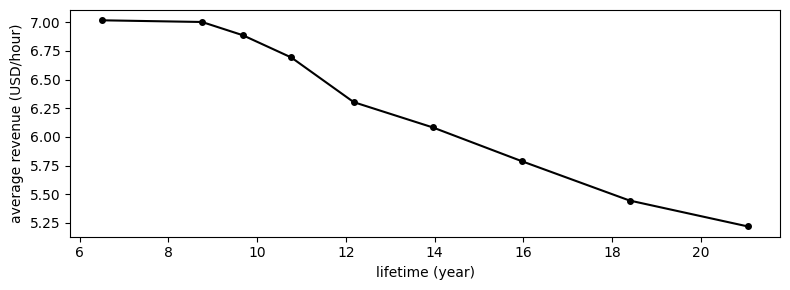


[DATA] tradeoff_curve: lifetime vs average_hourly_revenues
6.51027	7.017182
8.75811	7.002517
9.67603	6.887334
10.7716	6.692864
12.1785	6.303396
13.9597	6.083158
15.9719	5.787782
18.3965	5.445540
21.0606	5.219722


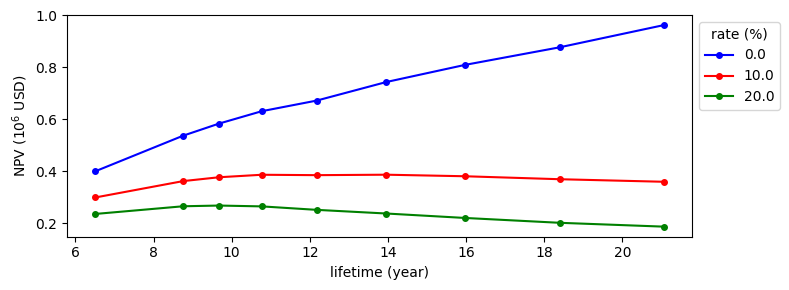


[DATA] net_present_value: lifetime vs NPV (by rate)
rate=0.000	6.51027	0.400190
rate=0.000	8.75811	0.537240
rate=0.000	9.67603	0.583784
rate=0.000	10.7716	0.631532
rate=0.000	12.1785	0.672472
rate=0.000	13.9597	0.743891
rate=0.000	15.9719	0.809792
rate=0.000	18.3965	0.877565
rate=0.000	21.0606	0.962992
rate=0.100	6.51027	0.299306
rate=0.100	8.75811	0.362355
rate=0.100	9.67603	0.377174
rate=0.100	10.7716	0.386782
rate=0.100	12.1785	0.385228
rate=0.100	13.9597	0.387008
rate=0.100	15.9719	0.381014
rate=0.100	18.3965	0.369583
rate=0.100	21.0606	0.359770
rate=0.200	6.51027	0.235898
rate=0.200	8.75811	0.265467
rate=0.200	9.67603	0.268231
rate=0.200	10.7716	0.264997
rate=0.200	12.1785	0.251635
rate=0.200	13.9597	0.237555
rate=0.200	15.9719	0.220470
rate=0.200	18.3965	0.201819
rate=0.200	21.0606	0.187022


In [19]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'tradeoff_curve.pdf'
file_path = os.path.join(output_dir, file_name)
lifetimes = np.array(bls)
average_hourly_revenues = np.zeros((len(bvs)))
for j in range(len(bvs)):
    average_hourly_revenues[j] = np.mean(bvs[j]['revenue'])
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
axes.plot(lifetimes, average_hourly_revenues, color = 'black', linestyle = 'solid', marker = 'o', markersize = 4)
axes.set_xlabel('lifetime (year)')
axes.set_ylabel('average revenue (USD/hour)')
axes.grid(False)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()


# === 打印数据点 ===
print("\n[DATA] tradeoff_curve: lifetime vs average_hourly_revenues")
for x, y in zip(lifetimes, average_hourly_revenues):
    print(f"{x:.6g}\t{y:.6f}")


pbs = []
for j in range(len(bvs)):
    pbs.append(bvs[j]['revenue'])

def calculate_npv(revenue, annual_rate):
    hours_per_year = 365 * 24
    t = np.arange(1, len(revenue) + 1)
    discount_factors = (1 + annual_rate) ** (-t / hours_per_year)
    npv = np.sum(revenue * discount_factors)
    return npv

def calculate_npv_metrics(pbs, rates):
    num_pbs = len(pbs)
    num_rates = len(rates)
    total_npv = np.zeros((num_pbs, num_rates))
    average_npv_hourly = np.zeros((num_pbs, num_rates))
    cumsum_npv_revenues = [[] for _ in range(num_pbs)]
    
    for j in range(num_pbs):
        for k in range(num_rates):
            revenue = pbs[j]
            rate = rates[k]
            npv = calculate_npv(revenue, rate)
            total_npv[j, k] = npv
            average_npv_hourly[j, k] = npv / len(revenue)
            discount_factors = (1 + rate) ** (-np.arange(1, len(revenue) + 1) / (365 * 24))
            discounted_revenue = revenue * discount_factors
            cumsum_npv_revenues[j].append(np.cumsum(discounted_revenue))
    
    return total_npv, average_npv_hourly, cumsum_npv_revenues

rates = np.array([0.00, 0.1, 0.2])
total_npv, average_npv_hourly, cumsum_npv_revenues = calculate_npv_metrics(pbs, rates)

output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'net_present_value.pdf'
file_path = os.path.join(output_dir, file_name)
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
cmap = coolwarm
colors = ['blue', 'red', 'green']
for j, rate in enumerate(rates):
    axes.plot(lifetimes, total_npv[:, j]/1e6,
              color=colors[j], linestyle='solid',
              marker='o', markersize=4,
              label=f"{rate*100:.1f}")
axes.set_xlabel('lifetime (year)')
#axes.set_xlim([0.0, 22])
axes.set_ylabel(r'NPV ($10^6$ USD)')
axes.legend(title='rate (%)', loc='upper left', bbox_to_anchor=(1, 1))
axes.grid(False)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

# === 打印数据点 ===
print("\n[DATA] net_present_value: lifetime vs NPV (by rate)")
for j, rate in enumerate(rates):
    for x, y in zip(lifetimes, total_npv[:, j] / 1e6):
        print(f"rate={rate:.3f}\t{x:.6g}\t{y:.6f}")

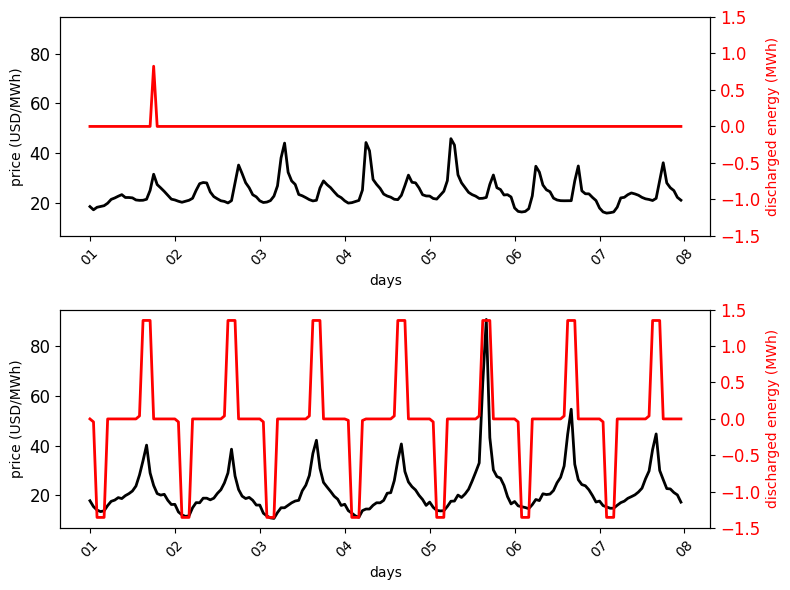


[DATA] weekly_profile_arbitrage — Week A (Jan): price vs time
2012-01-01 00:00	18.490000
2012-01-01 01:00	17.200000
2012-01-01 02:00	18.210000
2012-01-01 03:00	18.530000
2012-01-01 04:00	18.850000
2012-01-01 05:00	19.840000
2012-01-01 06:00	21.390000
2012-01-01 07:00	21.950000
2012-01-01 08:00	22.660000
2012-01-01 09:00	23.290000
2012-01-01 10:00	22.150000
2012-01-01 11:00	22.140000
2012-01-01 12:00	22.000000
2012-01-01 13:00	21.150000
2012-01-01 14:00	20.990000
2012-01-01 15:00	21.030000
2012-01-01 16:00	21.440000
2012-01-01 17:00	25.000000
2012-01-01 18:00	31.490000
2012-01-01 19:00	27.330000
2012-01-01 20:00	26.000000
2012-01-01 21:00	24.590000
2012-01-01 22:00	23.060000
2012-01-01 23:00	21.490000
2012-01-02 00:00	21.150000
2012-01-02 01:00	20.630000
2012-01-02 02:00	20.230000
2012-01-02 03:00	20.640000
2012-01-02 04:00	21.030000
2012-01-02 05:00	21.830000
2012-01-02 06:00	25.000000
2012-01-02 07:00	27.710000
2012-01-02 08:00	28.170000
2012-01-02 09:00	28.000000
2012-01-02 10:00	24

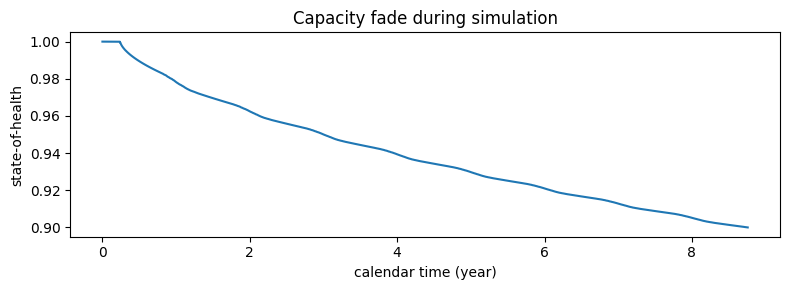


[DATA] SoH trajectory: years vs SoH
0.000000	1.000000
0.000114	1.000000
0.000228	1.000000
0.000342	1.000000
0.000457	1.000000
0.000571	1.000000
0.000685	1.000000
0.000799	1.000000
0.000913	1.000000
0.001027	1.000000
0.001142	1.000000
0.001256	1.000000
0.001370	1.000000
0.001484	1.000000
0.001598	1.000000
0.001712	1.000000
0.001826	1.000000
0.001941	1.000000
0.002055	0.999942
0.002169	0.999942
0.002283	0.999942
0.002397	0.999942
0.002511	0.999942
0.002626	0.999942
0.002740	0.999942
0.002854	0.999942
0.002968	0.999942
0.003082	0.999942
0.003196	0.999942
0.003311	0.999942
0.003425	0.999942
0.003539	0.999942
0.003653	0.999942
0.003767	0.999942
0.003881	0.999942
0.003995	0.999942
0.004110	0.999942
0.004224	0.999942
0.004338	0.999942
0.004452	0.999942
0.004566	0.999942
0.004680	0.999942
0.004795	0.999942
0.004909	0.999942
0.005023	0.999942
0.005137	0.999942
0.005251	0.999942
0.005365	0.999942
0.005479	0.999942
0.005594	0.999942
0.005708	0.999942
0.005822	0.999942
0.005936	0.999942
0.006050	

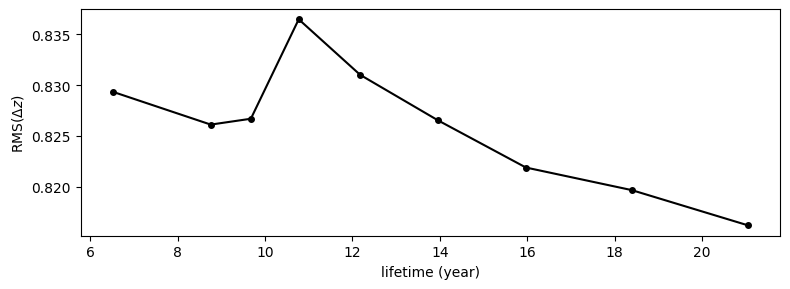


[DATA] smoothing tradeoff: lifetime vs RMS(Δz)
6.510274	0.829362
8.758105	0.826122
9.676027	0.826699
10.771575	0.836497
12.178539	0.831023
13.959703	0.826539
15.971918	0.821891
18.396461	0.819664
21.060616	0.816187


In [20]:

k = 1
battery_variables = bvs[k]
cell_variables = cvs[k]
revenue = battery_variables['revenue']
p = battery_variables['p']
hat_p = battery_variables['hat_p']
tilde_b = cell_variables['tilde_b']
tilde_q = cell_variables['tilde_q']
tilde_Q = cell_variables['tilde_Q']
tilde_delta_q = cell_variables['tilde_delta_q']
tilde_hat_q = cell_variables['tilde_hat_q']
l = cell_variables['l']
ah = cell_variables['ah']
mu_one_plus_nu_q = cell_variables['mu_one_plus_nu_q']
Sigma_rho = cell_variables['Sigma_rho']
tilde_b = tilde_b*cell_constants['cons_delta']*cell_constants['tilde_V']*cell_constants['N']

output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'weekly_profile_arbitrage.pdf'
file_path = os.path.join(output_dir, file_name)
times_jan = pd.date_range(start = '2012-01-01 00:00', end = '2012-01-07 23:00', freq='h')
times_jun = pd.date_range(start = '2012-06-01 00:00', end = '2012-06-07 23:00', freq='h')
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
axes[0].plot(times_jan, p[:24*7], label=r'$p_t$', color='black', linewidth=2, zorder=1)
axes[0].set_xlabel('days')
axes[0].set_ylabel('price (USD/MWh)', color="black")
axes[0].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[0].grid(False)
ax2 = axes[0].twinx()
ax2.plot(times_jan, tilde_b[:24*7], label=r'$\tilde b_t$', color='red', linewidth=2, zorder=2)
ax2.set_ylabel('discharged energy (MWh)', color='red') 
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
axes[0].xaxis.set_major_formatter(DateFormatter('%d'))
axes[0].tick_params(axis='x', rotation=45)
ax2.set_ylim([-1.5, 1.5])

axes[1].plot(times_jan, p[24*151:24*158], label=r'$p_t$', color='black', linewidth=2, zorder=1)
axes[1].set_xlabel('days')
axes[1].set_ylabel('price (USD/MWh)', color='black')
axes[1].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[1].grid(False)
ax4 = axes[1].twinx()
ax4.plot(times_jan, tilde_b[24*151:24*158], label=r'$\tilde b_t$', color='red', linewidth=2, zorder=2)
ax4.set_ylabel('discharged energy (MWh)', color='red') 
ax4.tick_params(axis='y', labelcolor='red', labelsize=12)
axes[1].xaxis.set_major_formatter(DateFormatter('%d'))
axes[1].tick_params(axis='x', rotation=45)
ax4.set_ylim([-1.5, 1.5])
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

# === 打印数据点 ===
print("\n[DATA] weekly_profile_arbitrage — Week A (Jan): price vs time")
for t, y in zip(times_jan, p[:24*7]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] weekly_profile_arbitrage — Week A (Jan): discharged energy vs time")
for t, y in zip(times_jan, tilde_b[:24*7]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")

print("\n[DATA] weekly_profile_arbitrage — Week B (indices 24*151:24*158): price vs time")
for t, y in zip(times_jan, p[24*151:24*158]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] weekly_profile_arbitrage — Week B: discharged energy vs time")
for t, y in zip(times_jan, tilde_b[24*151:24*158]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")


# ---------- NEW : SoH trajectory ----------
years = np.arange(len(tilde_Q)) / (365*24*(1/cell_constants['cons_delta']))
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(years, tilde_Q / cell_constants['tilde_Q_1'])
ax.set_xlabel('calendar time (year)')
ax.set_ylabel('state-of-health')
ax.set_title('Capacity fade during simulation')
ax.grid(False)
fig.tight_layout()
fig.savefig('./figures/SoH_trajectory.pdf')
plt.show()

# === 打印数据点 ===
print("\n[DATA] SoH trajectory: years vs SoH")
for x, y in zip(years, (tilde_Q / cell_constants['tilde_Q_1'])):
    print(f"{x:.6f}\t{y:.6f}")


# ─── 平滑器的 Δz 均方根 ───
rms_delta_z = np.array([
    np.sqrt(np.mean(cv['tilde_delta_q']**2))
    for cv in cvs
])

file_name = 'tradeoff_curve_smoothing.pdf'
file_path = os.path.join(output_dir, file_name)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(lifetimes, rms_delta_z,
        color='black', linestyle='solid',
        marker='o', markersize=4)
ax.set_xlabel('lifetime (year)')
ax.set_ylabel(r'RMS($\Delta z$)')
ax.grid(False)
fig.tight_layout()
# fig.savefig(file_path, bbox_inches='tight')
plt.show()

# === 打印数据点 ===
print("\n[DATA] smoothing tradeoff: lifetime vs RMS(Δz)")
for x, y in zip(lifetimes, rms_delta_z):
    print(f"{x:.6f}\t{y:.6f}")


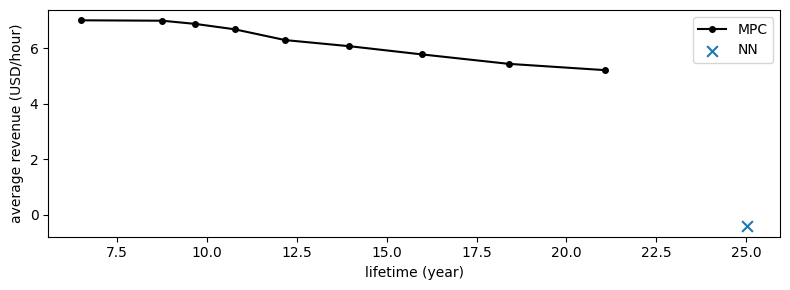


[DATA] NN arbitrage — Plot1: lifetime vs avg revenue (MPC & NN)
MPC	6.510274	7.017182
MPC	8.758105	7.002517
MPC	9.676027	6.887334
MPC	10.771575	6.692864
MPC	12.178539	6.303396
MPC	13.959703	6.083158
MPC	15.971918	5.787782
MPC	18.396461	5.445540
MPC	21.060616	5.219722
NN	25.016324	-0.421654


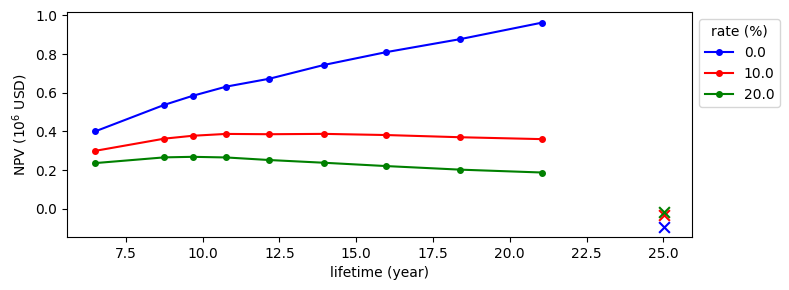


[DATA] NN arbitrage — Plot2: NPV (by rate) vs lifetime (MPC & NN)
MPC	rate=0.000	6.510274	0.400190
MPC	rate=0.000	8.758105	0.537240
MPC	rate=0.000	9.676027	0.583784
MPC	rate=0.000	10.771575	0.631532
MPC	rate=0.000	12.178539	0.672472
MPC	rate=0.000	13.959703	0.743891
MPC	rate=0.000	15.971918	0.809792
MPC	rate=0.000	18.396461	0.877565
MPC	rate=0.000	21.060616	0.962992
NN	rate=0.000	25.016324	-0.092403
MPC	rate=0.100	6.510274	0.299306
MPC	rate=0.100	8.758105	0.362355
MPC	rate=0.100	9.676027	0.377174
MPC	rate=0.100	10.771575	0.386782
MPC	rate=0.100	12.178539	0.385228
MPC	rate=0.100	13.959703	0.387008
MPC	rate=0.100	15.971918	0.381014
MPC	rate=0.100	18.396461	0.369583
MPC	rate=0.100	21.060616	0.359770
NN	rate=0.100	25.016324	-0.034226
MPC	rate=0.200	6.510274	0.235898
MPC	rate=0.200	8.758105	0.265467
MPC	rate=0.200	9.676027	0.268231
MPC	rate=0.200	10.771575	0.264997
MPC	rate=0.200	12.178539	0.251635
MPC	rate=0.200	13.959703	0.237555
MPC	rate=0.200	15.971918	0.220470
MPC	rate=0.200	18.396461

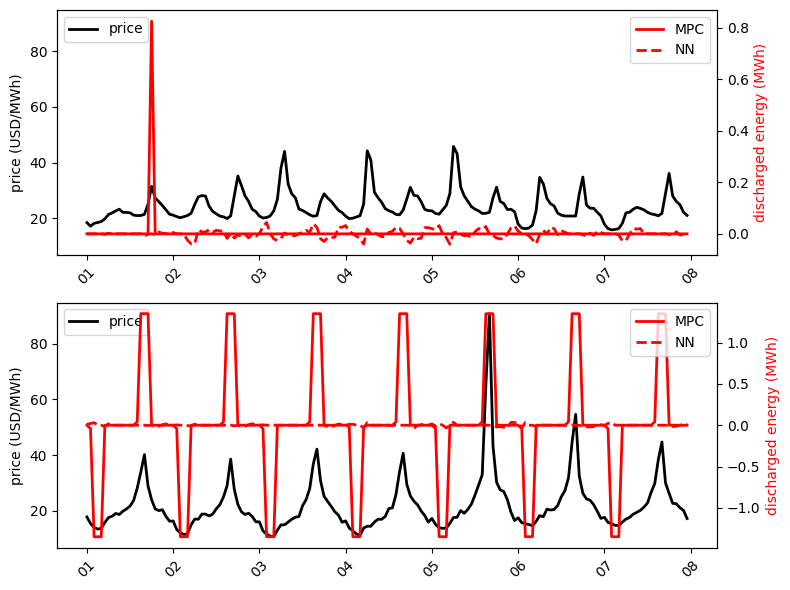


[DATA] NN arbitrage — Plot3 Week A: price vs time (MPC)
2012-01-01 00:00	18.490000
2012-01-01 01:00	17.200000
2012-01-01 02:00	18.210000
2012-01-01 03:00	18.530000
2012-01-01 04:00	18.850000
2012-01-01 05:00	19.840000
2012-01-01 06:00	21.390000
2012-01-01 07:00	21.950000
2012-01-01 08:00	22.660000
2012-01-01 09:00	23.290000
2012-01-01 10:00	22.150000
2012-01-01 11:00	22.140000
2012-01-01 12:00	22.000000
2012-01-01 13:00	21.150000
2012-01-01 14:00	20.990000
2012-01-01 15:00	21.030000
2012-01-01 16:00	21.440000
2012-01-01 17:00	25.000000
2012-01-01 18:00	31.490000
2012-01-01 19:00	27.330000
2012-01-01 20:00	26.000000
2012-01-01 21:00	24.590000
2012-01-01 22:00	23.060000
2012-01-01 23:00	21.490000
2012-01-02 00:00	21.150000
2012-01-02 01:00	20.630000
2012-01-02 02:00	20.230000
2012-01-02 03:00	20.640000
2012-01-02 04:00	21.030000
2012-01-02 05:00	21.830000
2012-01-02 06:00	25.000000
2012-01-02 07:00	27.710000
2012-01-02 08:00	28.170000
2012-01-02 09:00	28.000000
2012-01-02 10:00	24.37000

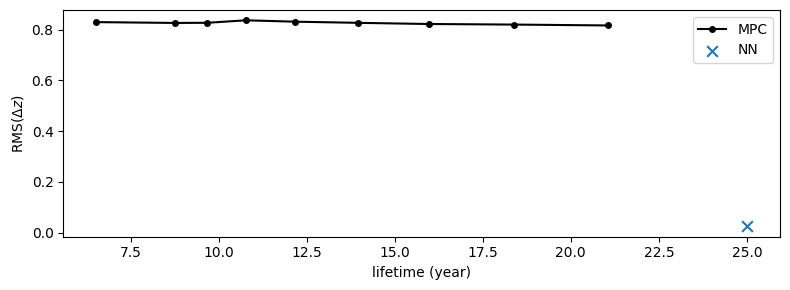


[DATA] NN arbitrage — RMS(Δz) vs lifetime (MPC & NN)
MPC	6.510274	0.829362
MPC	8.758105	0.826122
MPC	9.676027	0.826699
MPC	10.771575	0.836497
MPC	12.178539	0.831023
MPC	13.959703	0.826539
MPC	15.971918	0.821891
MPC	18.396461	0.819664
MPC	21.060616	0.816187
NN	25.016324	0.024123


In [21]:
# ==== NN for arbitrage: standalone postscript cell ====
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

# -------- safety: fallbacks --------
def _have(name): return name in globals() and globals()[name] is not None
assert _have('bvs') and _have('cvs') and _have('bls') and _have('f_test') and _have('cell_constants'), \
    "请先运行前面的单元，得到 bvs, cvs, bls, f_test, cell_constants"

if 'calculate_npv' not in globals():
    def calculate_npv(revenue, annual_rate):
        hours_per_year = 365 * 24
        t = np.arange(1, len(revenue) + 1)
        discount_factors = (1 + annual_rate) ** (-t / hours_per_year)
        return np.sum(revenue * discount_factors)

# -------- dataset from MPC rollouts --------
def build_arbitrage_dataset(bvs, cvs, cell_constants, W):
    H = cell_constants['H']
    Xs, Ys = [], []
    for k in range(len(bvs)):
        if (bvs[k] is None) or (cvs[k] is None):
            continue
        p   = np.asarray(bvs[k]['p'])            # (T,)
        hat = np.asarray(bvs[k]['hat_p'])        # (T,H)
        b   = np.asarray(cvs[k]['tilde_b'])      # (T,)
        q   = np.asarray(cvs[k]['tilde_q'])      # (T,)
        Q   = np.asarray(cvs[k]['tilde_Q'])      # (T,)

        T = min(len(p), len(hat), len(b), len(q), len(Q))
        for t in range(T):
            # 价格历史窗口
            t0 = max(0, t - W)
            hist = p[t0:t]
            if len(hist) < W:
                pad = np.full(W - len(hist), p[0] if len(p) else 0.0)
                hist = np.concatenate([pad, hist])
            # 未来 H 小时价格
            fut = hat[t] if t < hat.shape[0] else np.tile(p[t], H)
            soc = q[t] / max(Q[t], 1e-8)
            soh = Q[t] / cell_constants['tilde_Q_1']
            Xs.append(np.concatenate([hist, fut, [soc, soh]]))
            Ys.append(b[t])
    X = np.asarray(Xs, dtype=np.float32)
    Y = np.asarray(Ys, dtype=np.float32)
    return X, Y

# -------- model / train --------
class PolicyNet(nn.Module):
    def __init__(self, in_dim, hidden=(128,128)):
        super().__init__()
        layers = []
        n = in_dim
        for h in hidden:
            layers += [nn.Linear(n, h), nn.ReLU()]
            n = h
        layers += [nn.Linear(n, 1)]
        self.f = nn.Sequential(*layers)
    def forward(self, x):  # (N,D)->(N,)
        return self.f(x).squeeze(-1)

def train_policy(X, Y, epochs=12, batch_size=2048, lr=1e-3):
    x_mu, x_std = X.mean(axis=0), X.std(axis=0) + 1e-8
    y_mu, y_std = Y.mean(), Y.std() + 1e-8
    Xn = (X - x_mu) / x_std
    Yn = (Y - y_mu) / y_std
    ds = TensorDataset(torch.from_numpy(Xn), torch.from_numpy(Yn))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = PolicyNet(X.shape[1]).train()
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.SmoothL1Loss()
    for _ in range(epochs):
        for xb, yb in dl:
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    norms = dict(x_mu=x_mu, x_std=x_std, y_mu=y_mu, y_std=y_std)
    return model, norms

# -------- simulate with NN policy --------
def simulate_with_nn(f_test, cell_constants, model, norms, W):
    E, H = f_test.shape
    dlt = cell_constants['cons_delta']
    tilde_Q_t   = cell_constants['tilde_Q_1']
    tilde_q_t   = tilde_Q_t
    ah_t        = 2.5
    Sigma_rho_t = 0.0

    # 记录
    revenue   = np.zeros(E, dtype=float)
    p_series  = np.zeros(E, dtype=float)
    hat_p     = np.zeros((E, H), dtype=float)
    tilde_b   = np.zeros(E, dtype=float)
    tilde_q   = np.zeros(E, dtype=float)
    tilde_Q   = np.zeros(E, dtype=float)
    tilde_dq  = np.zeros(E, dtype=float)
    l_arr     = np.zeros(E, dtype=float)
    ah_arr    = np.zeros(E, dtype=float)
    mu1pnq    = np.zeros(E, dtype=float)
    Sig_rho   = np.zeros(E, dtype=float)

    price_hist = []
    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break
        p_vec = f_test[e]  # (H,)
        p_t   = p_vec[0]
        p_series[e] = p_t
        hat_p[e]    = p_vec
        price_hist  = (price_hist + [p_t])[-W:]
        if len(price_hist) < W:
            feat_hist = [price_hist[0]]*(W-len(price_hist)) + price_hist
        else:
            feat_hist = price_hist

        soc = tilde_q_t / max(tilde_Q_t, 1e-8)
        soh = tilde_Q_t / cell_constants['tilde_Q_1']
        x   = np.asarray(feat_hist + list(p_vec) + [soc, soh], dtype=np.float32)
        x_n = (x - norms['x_mu']) / norms['x_std']

        with torch.no_grad():
            b_n = model(torch.from_numpy(x_n).unsqueeze(0)).squeeze().item()
        b_t = b_n * norms['y_std'] + norms['y_mu']

        # 可行域投影
        b_lim = cell_constants['C_max'] * tilde_Q_t
        b_t   = float(np.clip(b_t, -b_lim, b_lim))
        q_new = float(np.clip(tilde_q_t - b_t * dlt, 0.0, tilde_Q_t))
        b_t   = (q_new - tilde_q_t) / dlt

        revenue[e] = p_t * b_t * dlt * cell_constants['tilde_V'] * cell_constants['N']

        # 老化一步（复用你前面定义的 aging 函数）
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            b_t, q_new, tilde_Q_t, ah_t + abs(b_t)*dlt, Sigma_rho_t, cell_constants, approx=False
        )
        ah_t += abs(b_t)*dlt
        mu1pnq_t = mu_t * (1 + nu_t * 0.5 * tilde_Q_t)

        tilde_b[e]  = b_t
        tilde_q[e]  = q_new
        tilde_Q[e]  = tilde_Q_t
        tilde_dq[e] = q_new - (tilde_q_t)
        l_arr[e]    = l_t
        ah_arr[e]   = ah_t
        mu1pnq[e]   = mu1pnq_t
        Sig_rho[e]  = Sigma_rho_t

        tilde_q_t = q_new

    num_hours = e
    # 裁剪
    revenue   = revenue[:num_hours]
    p_series  = p_series[:num_hours]
    hat_p     = hat_p[:num_hours]
    tilde_b   = tilde_b[:num_hours]
    tilde_q   = tilde_q[:num_hours]
    tilde_Q   = tilde_Q[:num_hours]
    tilde_dq  = tilde_dq[:num_hours]
    l_arr     = l_arr[:num_hours]
    ah_arr    = ah_arr[:num_hours]
    mu1pnq    = mu1pnq[:num_hours]
    Sig_rho   = Sig_rho[:num_hours]

    battery_lifetime = num_hours / (365*24*(1/cell_constants['cons_delta']))
    ah_end = ah_arr[-1] if len(ah_arr) else ah_t

    battery_variables = {'revenue': revenue, 'p': p_series, 'hat_p': hat_p}
    cell_variables    = {
        'tilde_b': tilde_b, 'tilde_Q': tilde_Q, 'tilde_q': tilde_q,
        'tilde_delta_q': tilde_dq, 'tilde_hat_q': hat_p, 'l': l_arr,
        'ah': ah_arr, 'mu_one_plus_nu_q': mu1pnq, 'Sigma_rho': Sig_rho
    }
    return battery_variables, cell_variables, battery_lifetime, ah_end

# -------- train & simulate --------
W_hist = 24
X_train, Y_train = build_arbitrage_dataset(bvs, cvs, cell_constants, W=W_hist)
assert len(X_train) > 0, "没有可用的训练样本，请检查 bvs/cvs 是否为空。"
model, norms = train_policy(X_train, Y_train, epochs=12, batch_size=2048, lr=1e-3)
bv_nn, cv_nn, life_nn, ah_end_nn = simulate_with_nn(f_test, cell_constants, model, norms, W=W_hist)

# -------- Plot 1: lifetime vs avg revenue (with NN point) --------
lifetimes = np.array(bls)
avg_rev   = np.array([np.mean(bv['revenue']) for bv in bvs])
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(lifetimes, avg_rev, color='black', linestyle='solid', marker='o', markersize=4, label='MPC')
ax.scatter([life_nn], [np.mean(bv_nn['revenue'])], marker='x', s=60, label='NN')
ax.set_xlabel('lifetime (year)')
ax.set_ylabel('average revenue (USD/hour)')
ax.grid(False); ax.legend()
plt.tight_layout(); plt.show()

# === 打印数据点 ===
print("\n[DATA] NN arbitrage — Plot1: lifetime vs avg revenue (MPC & NN)")
for x, y in zip(lifetimes, avg_rev):
    print(f"MPC\t{x:.6f}\t{y:.6f}")
print(f"NN\t{life_nn:.6f}\t{np.mean(bv_nn['revenue']):.6f}")

# -------- Plot 2: NPV vs lifetime (with NN points) --------
rates = np.array([0.00, 0.1, 0.2])
def batch_npv(pbs, rates):
    out = np.zeros((len(pbs), len(rates)))
    for j, rv in enumerate(pbs):
        for k, r in enumerate(rates):
            out[j,k] = calculate_npv(rv, r)
    return out

pbs = [bv['revenue'] for bv in bvs]
npv_mpc = batch_npv(pbs, rates) / 1e6
fig, ax = plt.subplots(figsize=(8,3))
colors = ['blue','red','green']
for j, r in enumerate(rates):
    ax.plot(lifetimes, npv_mpc[:,j], color=colors[j], marker='o', markersize=4, label=f'{r*100:.1f}')
    ax.scatter([life_nn], [calculate_npv(bv_nn['revenue'], r)/1e6], marker='x', s=60, color=colors[j])
ax.set_xlabel('lifetime (year)')
ax.set_ylabel(r'NPV ($10^6$ USD)')
ax.legend(title='rate (%)', loc='upper left', bbox_to_anchor=(1,1))
ax.grid(False)
plt.tight_layout(); plt.show()

# === 打印数据点 ===
print("\n[DATA] NN arbitrage — Plot2: NPV (by rate) vs lifetime (MPC & NN)")
for j, r in enumerate(rates):
    for x, y in zip(lifetimes, npv_mpc[:, j]):
        print(f"MPC\trate={r:.3f}\t{x:.6f}\t{y:.6f}")
    print(f"NN\trate={r:.3f}\t{life_nn:.6f}\t{calculate_npv(bv_nn['revenue'], r)/1e6:.6f}")



# -------- Plot 3: weekly profile (MPC vs NN) --------
k = 1 if len(bvs) > 1 else 0
p_k   = np.asarray(bvs[k]['p'])
tb_k  = np.asarray(cvs[k]['tilde_b']) * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N']
tb_nn = np.asarray(cv_nn['tilde_b'])  * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N']

times_jan = pd.date_range(start='2012-01-01 00:00', end='2012-01-07 23:00', freq='h')
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharey=True)

axes[0].plot(times_jan, p_k[:24*7], color='black', linewidth=2, zorder=1, label='price')
ax2 = axes[0].twinx()
ax2.plot(times_jan, tb_k[:24*7], color='red', linewidth=2, zorder=2, label='MPC')
ax2.plot(times_jan, tb_nn[:24*7], color='red', linestyle='--', linewidth=2, zorder=2, label='NN')
axes[0].set_ylabel('price (USD/MWh)')
ax2.set_ylabel('discharged energy (MWh)', color='red')
axes[0].xaxis.set_major_formatter(DateFormatter('%d')); axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left'); ax2.legend(loc='upper right')

axes[1].plot(times_jan, p_k[24*151:24*158], color='black', linewidth=2, zorder=1, label='price')
ax4 = axes[1].twinx()
ax4.plot(times_jan, tb_k[24*151:24*158], color='red', linewidth=2, zorder=2, label='MPC')
ax4.plot(times_jan, tb_nn[24*151:24*158], color='red', linestyle='--', linewidth=2, zorder=2, label='NN')
axes[1].set_ylabel('price (USD/MWh)')
ax4.set_ylabel('discharged energy (MWh)', color='red')
axes[1].xaxis.set_major_formatter(DateFormatter('%d')); axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper left'); ax4.legend(loc='upper right')

plt.tight_layout(); plt.show()

# === 打印数据点 ===
print("\n[DATA] NN arbitrage — Plot3 Week A: price vs time (MPC)")
for t, y in zip(times_jan, p_k[:24*7]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] NN arbitrage — Plot3 Week A: discharged energy (MPC)")
for t, y in zip(times_jan, tb_k[:24*7]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] NN arbitrage — Plot3 Week A: discharged energy (NN)")
for t, y in zip(times_jan, tb_nn[:24*7]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")

print("\n[DATA] NN arbitrage — Plot3 Week B: price vs time (MPC)")
for t, y in zip(times_jan, p_k[24*151:24*158]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] NN arbitrage — Plot3 Week B: discharged energy (MPC)")
for t, y in zip(times_jan, tb_k[24*151:24*158]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
print("[DATA] NN arbitrage — Plot3 Week B: discharged energy (NN)")
for t, y in zip(times_jan, tb_nn[24*151:24*158]):
    print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")


# -------- (optional) RMS(Δz) single point for NN --------
rms_mpc = np.array([np.sqrt(np.mean(np.square(cv['tilde_delta_q']))) for cv in cvs])
rms_nn  = float(np.sqrt(np.mean(np.square(cv_nn['tilde_delta_q']))))
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(lifetimes, rms_mpc, color='black', linestyle='solid', marker='o', markersize=4, label='MPC')
ax.scatter([life_nn], [rms_nn], marker='x', s=60, label='NN')
ax.set_xlabel('lifetime (year)'); ax.set_ylabel(r'RMS($\Delta z$)'); ax.grid(False); ax.legend()
plt.tight_layout(); plt.show()

# === 打印数据点 ===
print("\n[DATA] NN arbitrage — RMS(Δz) vs lifetime (MPC & NN)")
for x, y in zip(lifetimes, rms_mpc):
    print(f"MPC\t{x:.6f}\t{y:.6f}")
print(f"NN\t{life_nn:.6f}\t{rms_nn:.6f}")
